In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud

In [2]:
# Load all the relevant CSV files into Pandas DataFrames
customers_df = pd.read_csv('olist_customers_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv')
product_df = pd.read_csv("olist_products_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
seller_df = pd.read_csv("olist_sellers_dataset.csv")
payment_df = pd.read_csv("olist_order_payments_dataset.csv")
product_category_df = pd.read_csv("product_category_name_translation.csv")

In [3]:
df = pd.merge(order_items_df, product_df,on='product_id',how='outer')
df = pd.merge(df, seller_df, on='seller_id',how='outer')
df = pd.merge(df, orders_df,on='order_id',how='outer')
df = pd.merge(df, customers_df,on='customer_id',how='outer')
df = pd.merge(df, order_reviews_df,on='order_id',how='outer')
df = pd.merge(df, payment_df,on='order_id',how='outer')

df = df.merge(product_category_df, on='product_category_name', how='left')
df['product_category_name'] = df['product_category_name_english']
df.drop(['product_category_name'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   order_item_id                  118310 non-null  float64
 2   product_id                     118310 non-null  object 
 3   seller_id                      118310 non-null  object 
 4   shipping_limit_date            118310 non-null  object 
 5   price                          118310 non-null  float64
 6   freight_value                  118310 non-null  float64
 7   product_name_lenght            116601 non-null  float64
 8   product_description_lenght     116601 non-null  float64
 9   product_photos_qty             116601 non-null  float64
 10  product_weight_g               118290 non-null  float64
 11  product_length_cm              118290 non-null  float64
 12  product_height_cm             

In [5]:
# finding number of duplicate rows in geolocation dataset
geolocation_df.duplicated().sum()

261831

In [6]:
# removing duplicate rows
geolocation_df = geolocation_df.drop_duplicates()

In [7]:
# calculate mean_lat and mean_lng based on each geolocation_zip_code_prefix
mean_lat = geolocation_df.groupby('geolocation_zip_code_prefix')['geolocation_lat'].mean().reset_index()
mean_lng = geolocation_df.groupby('geolocation_zip_code_prefix')['geolocation_lng'].mean().reset_index()

mean_lat.rename(columns={'geolocation_lat': 'mean_lat'}, inplace=True)
mean_lng.rename(columns={'geolocation_lng': 'mean_lng'}, inplace=True)

geolocation_df = pd.merge(mean_lat, mean_lng, on='geolocation_zip_code_prefix')

In [8]:

df = pd.merge(df, geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.rename(columns={
    'mean_lat' : 'seller_lat',
    'mean_lng' : 'seller_lng'
}, inplace=True)

df.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

In [9]:
df = pd.merge(df, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.rename(columns={
    'mean_lat' : 'customer_lat',
    'mean_lng' : 'customer_lng'
}, inplace=True)

df.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

In [10]:
df.shape

(117729, 43)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117729 entries, 0 to 117728
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117729 non-null  object 
 1   order_item_id                  117729 non-null  float64
 2   product_id                     117729 non-null  object 
 3   seller_id                      117729 non-null  object 
 4   shipping_limit_date            117729 non-null  object 
 5   price                          117729 non-null  float64
 6   freight_value                  117729 non-null  float64
 7   product_name_lenght            116027 non-null  float64
 8   product_description_lenght     116027 non-null  float64
 9   product_photos_qty             116027 non-null  float64
 10  product_weight_g               117709 non-null  float64
 11  product_length_cm              117709 non-null  float64
 12  product_height_cm             

# Data Cleaning

number of duplicate rows:  (0, 43)
Number of rows with at least 1 missing values: 106199
Number of columns with missing values: 21

Missing percentage (desceding):


,Total,Percentage(%)
review_comment_title,103903,88.256080
review_comment_message,68277,57.995056
order_delivered_customer_date,2570,2.182980
product_category_name_english,1727,1.466928
product_name_lenght,1702,1.445693
product_description_lenght,1702,1.445693
product_photos_qty,1702,1.445693
order_delivered_carrier_date,1243,1.055815
review_answer_timestamp,976,0.829023
review_id,976,0.829023


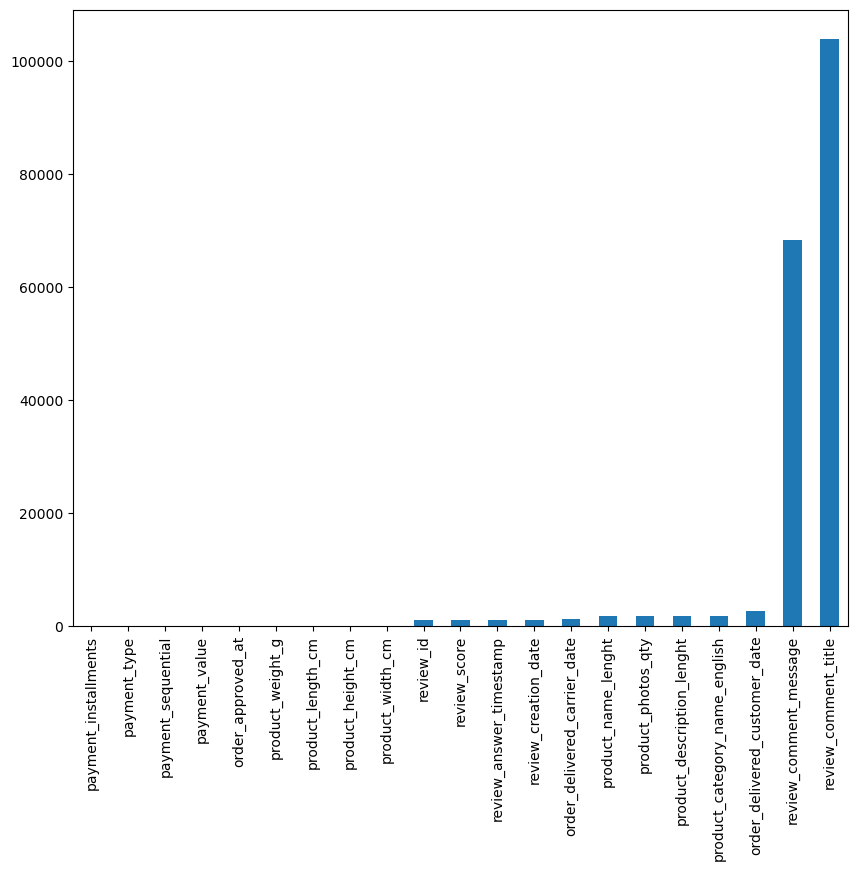

In [12]:
#handle duplicates
duplicate_rows=df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

def missing_value_describe(data):
    # check missing values in the data
    total = data.isna().sum().sort_values(ascending=False)
    missing_value_pct_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_pct_stats > 0)

    # missing_value_stats = missing_value_pct_stats.sort_values(ascending=False)[:missing_value_col_count]
    missing_data = pd.concat([total, missing_value_pct_stats], axis=1, keys=['Total', 'Percentage(%)'])

    print("Number of rows with at least 1 missing values:", data.isna().any(axis = 1).sum())
    print("Number of columns with missing values:", missing_value_col_count)

    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        display(missing_data[:missing_value_col_count])

        # plot missing values
        missing = data.isnull().sum()
        missing = missing[missing > 0]
        missing.sort_values(inplace=True)
        missing.plot.bar(figsize=(10,8))
    else:
        print("No missing data!!!")
missing_value_describe(df)

In [13]:
df.duplicated().sum()

0

In [14]:
df.isnull().sum()

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_name_lenght                1702
product_description_lenght         1702
product_photos_qty                 1702
product_weight_g                     20
product_length_cm                    20
product_height_cm                    20
product_width_cm                     20
seller_zip_code_prefix                0
seller_city                           0
seller_state                          0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1243
order_delivered_customer_date      2570
order_estimated_delivery_date         0
customer_unique_id                    0


In [16]:
# Filling missing values in 'product_description_lenght' with the median
df['product_description_lenght'].fillna(df['product_description_lenght'].median(), inplace=True)
# Filling missing values in 'product_photos_qty' with the mode
df['product_photos_qty'].fillna(df['product_photos_qty'].mode()[0], inplace=True)

df['product_category_name_english'].fillna(df['product_category_name_english'].mode()[0], inplace=True)
# Filling missing values in 'review_comment_message' with 'unavailable'
df['review_comment_message'].fillna(value='unavailable', inplace=True)

# Filling missing values in 'review_comment_title' with 'unavailable'
df['review_comment_title'].fillna(value='unavailable', inplace=True)

# Converting 'order_approved_at' to datetime format
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'], errors='coerce')
print(df['order_approved_at'].dtype)

# Now let's calculate the mean of 'order_approved_at'
mean_timestamp = df['order_approved_at'].mean()

# Filling missing 'order_approved_at' with the mean timestamp
df['order_approved_at'].fillna(mean_timestamp, inplace=True)

df.dropna(subset=['review_score'], inplace=True)  
df.fillna(0, inplace=True) 

df = df[(df['price'] >= 0) & (df['price'] <= 1000)]

datetime64[ns]


In [17]:
df.isnull().sum()

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
review_id           

In [18]:
#summary of descriptive s\tatistics
df.describe()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,seller_lat,seller_lng,customer_lat,customer_lng
count,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000,115879.000000
mean,1.195281,109.494296,19.717607,48.040939,776.061737,2.178108,2063.763926,30.180197,16.532193,22.991155,24411.095427,34939.581986,4.032025,1.094875,2.911416,160.146342,-22.804037,-47.251475,-21.241797,-46.197801
std,0.686379,120.344778,14.846675,11.548429,637.479440,1.705098,3679.883595,16.086129,13.365871,11.669349,27570.100705,29831.020651,1.386974,0.734629,2.745198,192.198862,2.666750,2.316804,5.555837,4.037465
min,1.000000,0.850000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1001.000000,1003.000000,1.000000,0.000000,0.000000,0.000000,-32.075303,-67.813790,-33.689890,-72.668821
25%,1.000000,39.900000,13.010000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6440.000000,11075.000000,4.000000,1.000000,1.000000,60.220000,-23.607700,-48.829541,-23.590430,-48.097847
50%,1.000000,73.500000,16.220000,51.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24220.000000,5.000000,1.000000,1.000000,107.340000,-23.424361,-46.756262,-22.929465,-46.632063
75%,1.000000,129.990000,21.080000,57.000000,966.000000,3.000000,1775.000000,38.000000,20.000000,30.000000,27277.000000,58152.500000,5.000000,1.000000,4.000000,186.645000,-21.757225,-46.521557,-20.197763,-43.629728
max,21.000000,1000.000000,409.680000,76.000000,3988.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99990.000000,5.000000,29.000000,24.000000,6081.540000,-2.503158,-34.855831,42.184003,-8.723762


In [19]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / (3600 * 24)  

In [20]:
df['order_delivery_time'].head()

0     7.614421
1    31.985278
2    14.428449
3    10.125995
4    12.212269
Name: order_delivery_time, dtype: float64

In [21]:
customer_AvgReview = df.groupby('customer_id')['review_score'].mean()
df = df.merge(customer_AvgReview, on='customer_id', suffixes=('', '_avg_review'))

customer_reviewCount = df['customer_id'].value_counts().reset_index()
customer_reviewCount.columns = ['customer_id', 'customer_reviewCount']
df = df.merge(customer_reviewCount, on='customer_id')

In [22]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value',
       'product_category_name_english', 'seller_lat', 'seller_lng',
       'customer_lat', 'customer_lng', 'order_deli

In [23]:
# df.to_excel('cus.xlsx', index = True)

In [24]:
# Calculating the relationship between features and the target variable uding numeric columns only
corr_matrix = df.corr(numeric_only=True)
correlation_with_target = corr_matrix['review_score'].abs().sort_values(ascending=False)
print(correlation_with_target)

review_score                  1.000000
review_score_avg_review       0.998218
order_delivery_time           0.238185
order_item_id                 0.129010
payment_value                 0.097378
customer_reviewCount          0.081264
payment_installments          0.042037
customer_lng                  0.041520
freight_value                 0.039110
customer_lat                  0.035934
product_weight_g              0.028900
seller_zip_code_prefix        0.025772
product_height_cm             0.025598
product_photos_qty            0.024332
customer_zip_code_prefix      0.023597
product_length_cm             0.019792
product_width_cm              0.011342
product_description_lenght    0.011301
seller_lng                    0.010872
seller_lat                    0.007882
payment_sequential            0.004803
product_name_lenght           0.002506
price                         0.000916
Name: review_score, dtype: float64


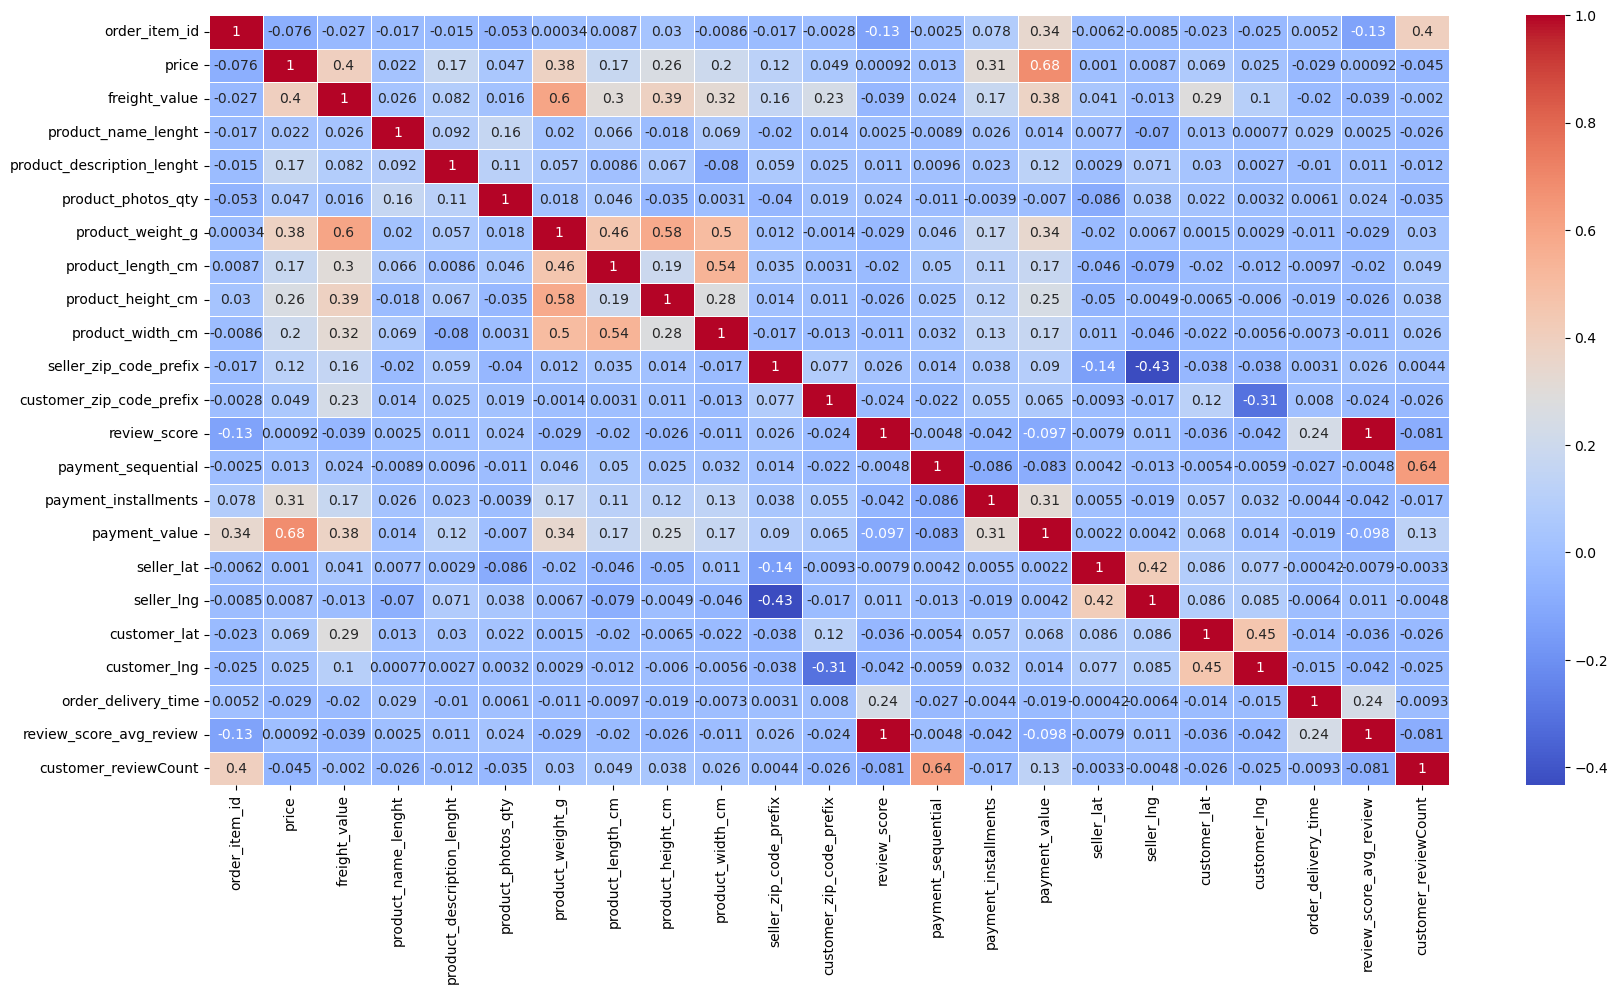

In [25]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5);

In [26]:
correlation_threshold = 0.1
correlated_features = df.corr(numeric_only=True)['review_score'][abs(df.corr(numeric_only=True)['review_score']) > correlation_threshold].index.tolist()

print(correlated_features)

['order_item_id', 'review_score', 'order_delivery_time', 'review_score_avg_review']


# creating customer satisfaction columns

In [27]:
# any review score less than 3 will be unsatisfied
# review score from 3 and above will be satisfied

df['customer_satisfaction'] = np.where(df['review_score'] >= 3, 'satisfied', 'unsatisfied')

In [28]:
df['customer_satisfaction'].value_counts()

satisfied      97207
unsatisfied    18672
Name: customer_satisfaction, dtype: int64

Now using label encoder to convert the new column (customer satistaction) satisfied customer = 1 and unsatisfied customer = 0

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['customer_satisfaction_encoded'] = label_encoder.fit_transform(df['customer_satisfaction'])

In [30]:
df['customer_satisfaction_encoded'].value_counts()

0    97207
1    18672
Name: customer_satisfaction_encoded, dtype: int64

In [31]:
df.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,product_category_name_english,seller_lat,seller_lng,customer_lat,customer_lng,order_delivery_time,review_score_avg_review,customer_reviewCount,customer_satisfaction,customer_satisfaction_encoded
61042,8adc844e30dc63531a489163134ad405,1.0,35537536ed2b4c561b4018bf3abf54e0,955fee9216a65b617aa5c0531780ce60,2018-07-02 20:15:12,390.0,29.03,59.0,1459.0,9.0,...,sports_leisure,-23.690813,-46.703852,-16.326908,-48.941706,8.999329,4.0,1,satisfied,0
58255,133a94aa41cab8ad1d4cf02c2636b9cc,2.0,4f18ca9862f511ecba98258b2194d061,5b0cc932433fa5184b5b94bfe6bcc256,2018-08-01 09:30:11,95.0,59.90,20.0,252.0,1.0,...,furniture_bedroom,-21.757225,-48.829541,-22.797707,-43.181631,11.432303,1.0,14,unsatisfied,1
6380,c870c1f3a9ba62194d1060c0accb18dd,1.0,b4f9530c931398e215242293c2c8ba4c,4e922959ae960d389249c378d1c939f5,2017-01-28 11:15:23,45.0,11.03,59.0,1542.0,3.0,...,fixed_telephony,-23.302362,-45.971900,-22.859753,-47.053967,9.353090,4.0,1,satisfied,0


In [32]:
from textblob import TextBlob

df['sentiment'] = df['review_comment_message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

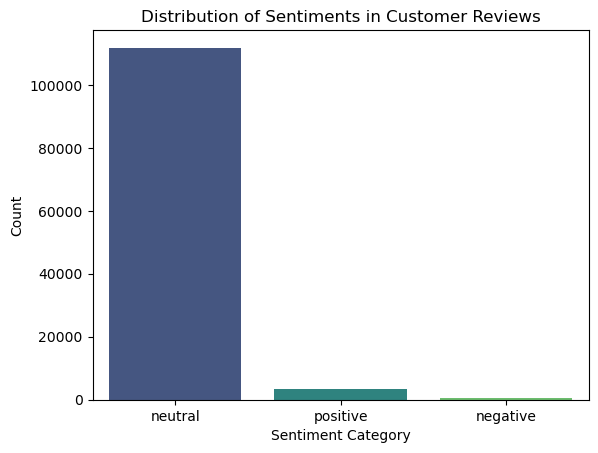

In [33]:
sns.countplot(x='sentiment_category', data=df, palette='viridis')
plt.title('Distribution of Sentiments in Customer Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

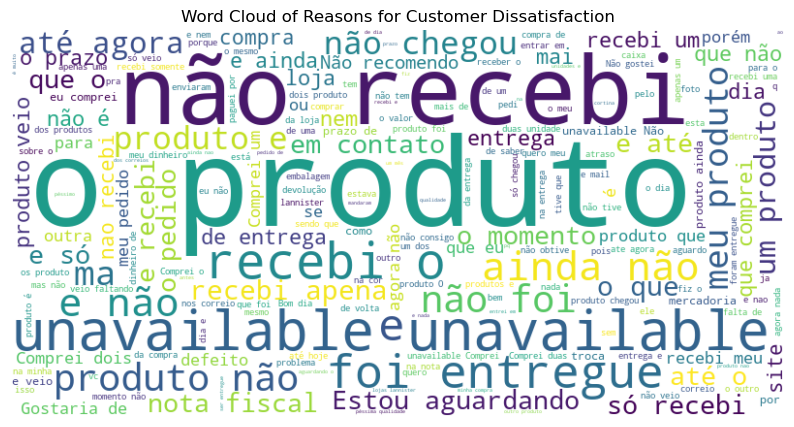

In [34]:
unsatisfied_reviews = df[df['review_score'] < 3]['review_comment_message']

# Combine all unsatisfied reviews into a single string
unsatisfied_text = ' '.join(unsatisfied_reviews)

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unsatisfied_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reasons for Customer Dissatisfaction')
plt.show()

In [35]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,seller_lng,customer_lat,customer_lng,order_delivery_time,review_score_avg_review,customer_reviewCount,customer_satisfaction,customer_satisfaction_encoded,sentiment,sentiment_category
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,58.0,598.0,4.0,...,-44.127324,-21.763186,-41.310265,7.614421,5.0,1,satisfied,0,0.0,neutral
1,5c94ad4e194c0e6794688a9d2b9ea94b,1.0,e0cf79767c5b016251fe139915c59a26,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-16 18:50:24,29.9,18.23,55.0,388.0,1.0,...,-47.664918,-21.763186,-41.310265,31.985278,2.0,1,unsatisfied,1,0.0,neutral
2,bd31b009e1dbc47fc7c250b1e2cf5440,1.0,92e2d2146e433cd4d1f09a3f8633ead0,4a3ca9315b744ce9f8e9374361493884,2018-05-02 03:51:18,52.9,22.95,53.0,714.0,1.0,...,-48.829541,-21.763186,-41.310265,14.428449,3.0,1,satisfied,0,0.0,neutral
3,bb4eb0196897c20281a61f75ce23211c,1.0,8cee1d824765335c48ccc515c2ecf4b8,4a3ca9315b744ce9f8e9374361493884,2017-07-28 14:50:11,96.0,15.42,54.0,385.0,2.0,...,-48.829541,-21.763186,-41.310265,10.125995,5.0,1,satisfied,0,0.0,neutral
4,f9847bf9cc7336c6ba07fe2bdbb6cae1,1.0,3e5201fe0d1ba474d9b90152c83c706c,8160255418d5aaa7dbdc9f4c64ebda44,2018-05-16 18:30:50,125.9,13.30,56.0,255.0,1.0,...,-48.829541,-21.763186,-41.310265,12.212269,5.0,1,satisfied,0,0.0,neutral


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

reviews = df['review_comment_message']

vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(reviews)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Extracting the most important words from the review messages
feature_names = vectorizer.get_feature_names_out()
topic_words = {}

for topic_idx, topic in enumerate(lda.components_):
    top_feature_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_feature_idx]
    topic_words[f"Topic {topic_idx + 1}"] = top_words

# Display the top words
for topic, words in topic_words.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: bom, muito, produto, uma, veio, nota, duas, só, gostei, na
Topic 2: produto, prazo, antes, entrega, chegou, recomendo, muito, bem, tudo, qualidade
Topic 3: não, recebi, produto, um, comprei, que, foi, ainda, entregue, até
Topic 4: unavailable, 1000, otimo, normal, 100, legal, ta, ok, atrasou, boa
Topic 5: que, não, produto, com, na, mas, da, em, um, mais


In [37]:
dissatisfaction_reasons = {
    'Product Quality': ['bom', 'produto', 'qualidade', 'veio', 'nota', 'gostei'],
    'Delivery Time': ['prazo', 'entrega', 'chegou', 'recomendo', 'qualidade'],
    'Undelivered Product': ['não', 'recebi', 'comprou', 'entregue'],
    'Other Issues': ['atrasou', 'problema', 'ok', 'legal']
}

df['dissatisfaction_reason'] = df['review_comment_message'].apply(lambda review: next((reason for reason, keywords in dissatisfaction_reasons.items() 
                                                                                       if any(keyword in review for keyword in keywords)), 'Other'))

print(df['dissatisfaction_reason'].value_counts())

Other                  80080
Product Quality        22965
Delivery Time           8328
Undelivered Product     3944
Other Issues             562
Name: dissatisfaction_reason, dtype: int64


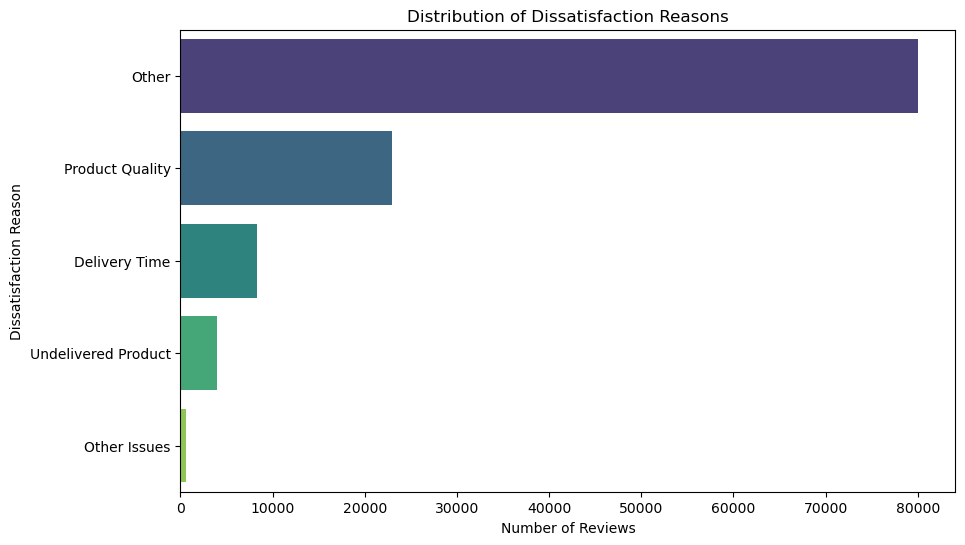

In [38]:
reasons = ['Other', 'Product Quality', 'Delivery Time', 'Undelivered Product', 'Other Issues']
counts = [80080, 22965, 8328, 3944, 562]

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=reasons, palette='viridis')
plt.title('Distribution of Dissatisfaction Reasons')
plt.xlabel('Number of Reviews')
plt.ylabel('Dissatisfaction Reason')
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115879 entries, 0 to 115878
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115879 non-null  object        
 1   order_item_id                  115879 non-null  float64       
 2   product_id                     115879 non-null  object        
 3   seller_id                      115879 non-null  object        
 4   shipping_limit_date            115879 non-null  object        
 5   price                          115879 non-null  float64       
 6   freight_value                  115879 non-null  float64       
 7   product_name_lenght            115879 non-null  float64       
 8   product_description_lenght     115879 non-null  float64       
 9   product_photos_qty             115879 non-null  float64       
 10  product_weight_g               115879 non-null  float64       
 11  

# Exploratory Data Analysis 

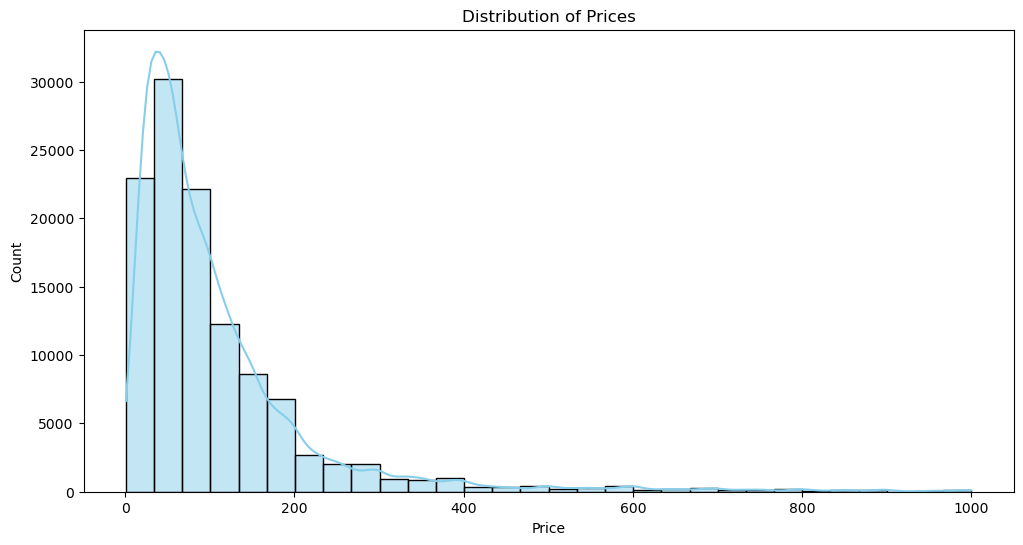

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.show()

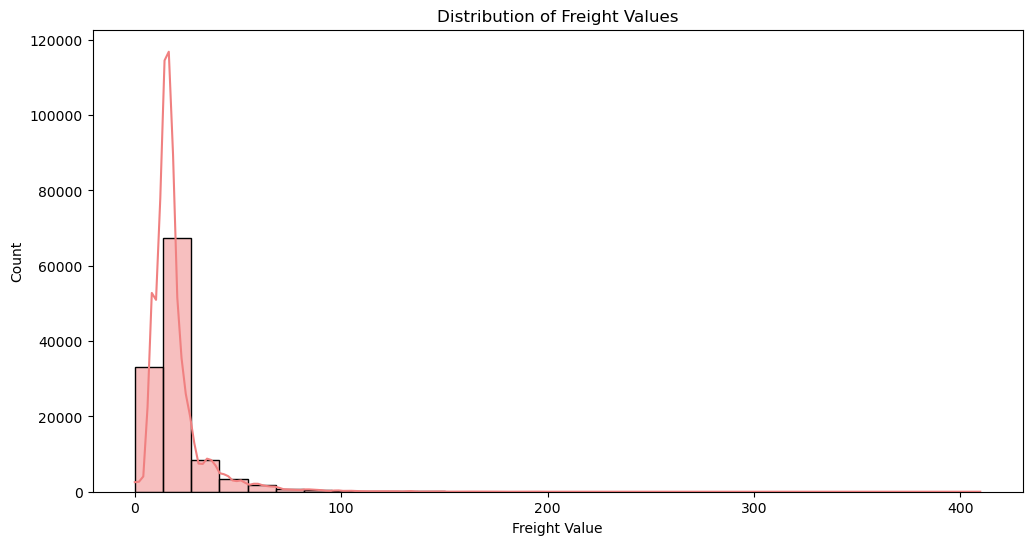

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='freight_value', bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Freight Values')
plt.xlabel('Freight Value')
plt.show()

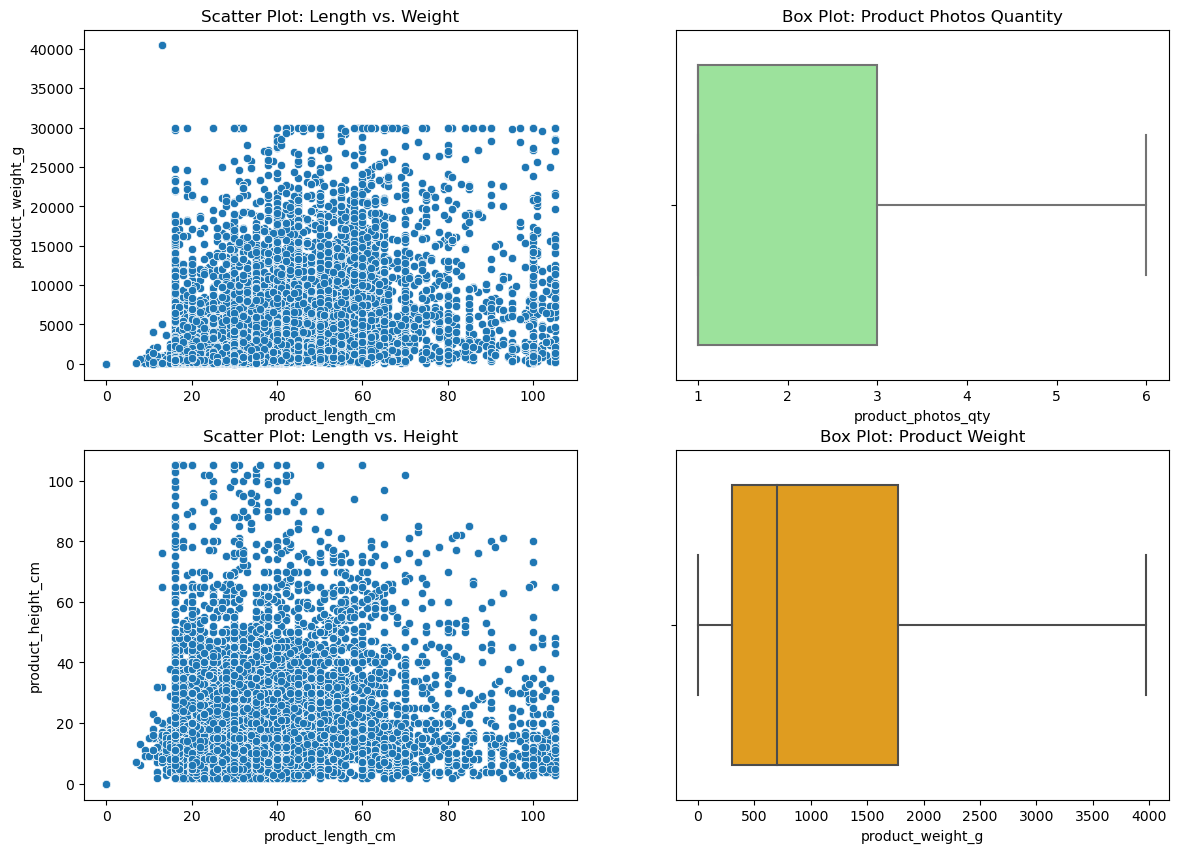

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df, x='product_length_cm', y='product_weight_g', ax=axes[0, 0])
axes[0, 0].set_title('Scatter Plot: Length vs. Weight')

sns.boxplot(data=df, x='product_photos_qty', ax=axes[0, 1], color='lightgreen', showfliers=False)
axes[0, 1].set_title('Box Plot: Product Photos Quantity')

sns.scatterplot(data=df, x='product_length_cm', y='product_height_cm', ax=axes[1, 0])
axes[1, 0].set_title('Scatter Plot: Length vs. Height')

sns.boxplot(data=df, x='product_weight_g', ax=axes[1, 1], color='orange', showfliers=False)
axes[1, 1].set_title('Box Plot: Product Weight')

plt.show()

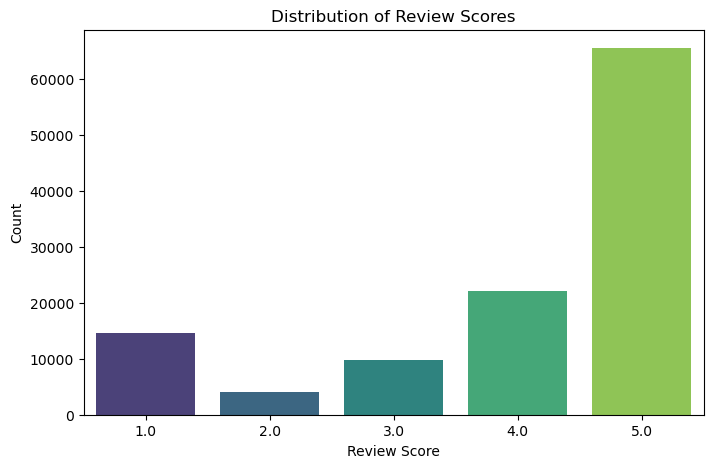

In [44]:
# Review Scores
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='review_score', palette='viridis')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

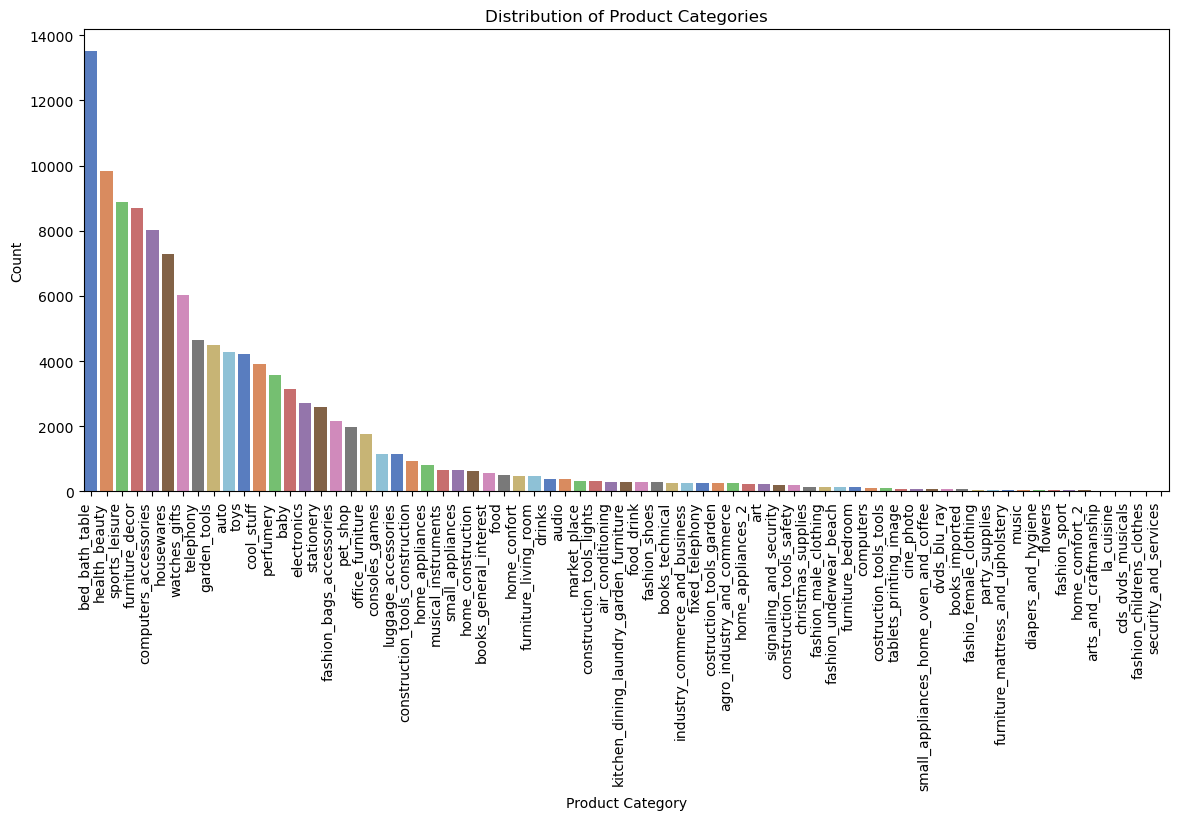

In [47]:
# Product Categories
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='product_category_name_english', palette='muted', order=df['product_category_name_english'].value_counts().index)
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Count')
plt.show()

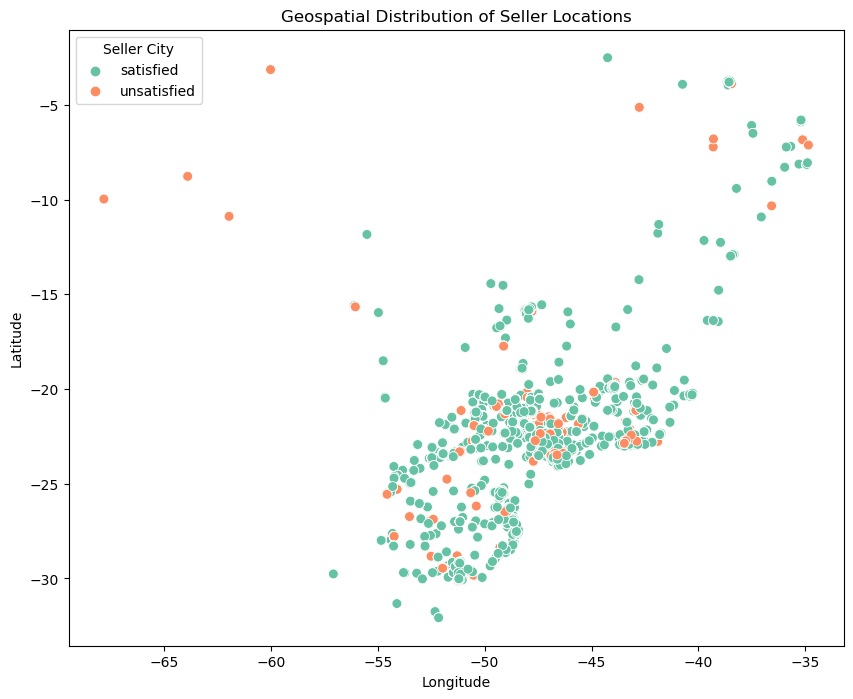

In [64]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='seller_lng', y='seller_lat', hue='customer_satisfaction', palette='Set2', s=50)
plt.title('Geospatial Distribution of Seller Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Seller City')
plt.show()

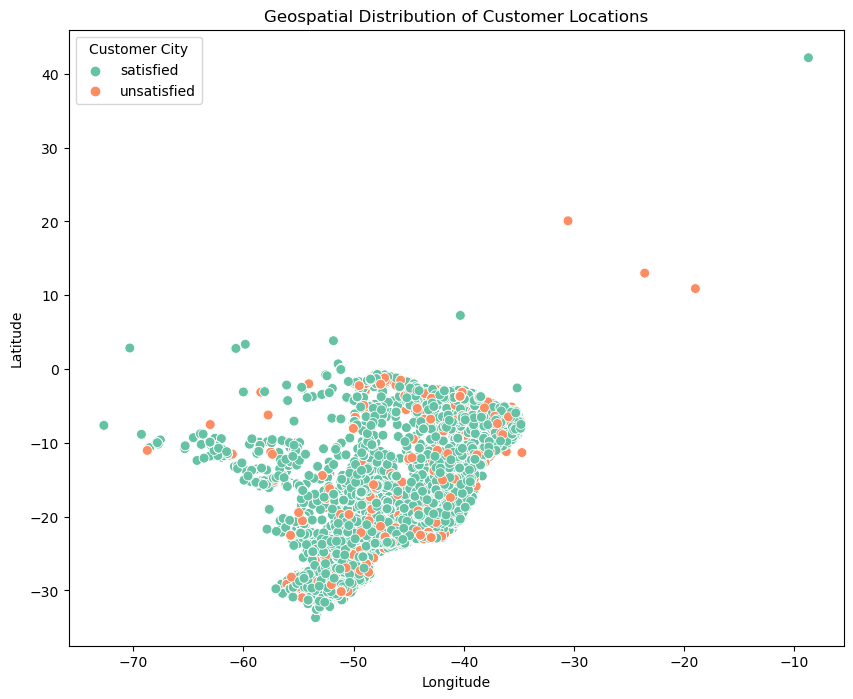

In [63]:
# Customer Location
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='customer_lng', y='customer_lat', hue='customer_satisfaction', palette='Set2', s=50)
plt.title('Geospatial Distribution of Customer Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Customer City')
plt.show()

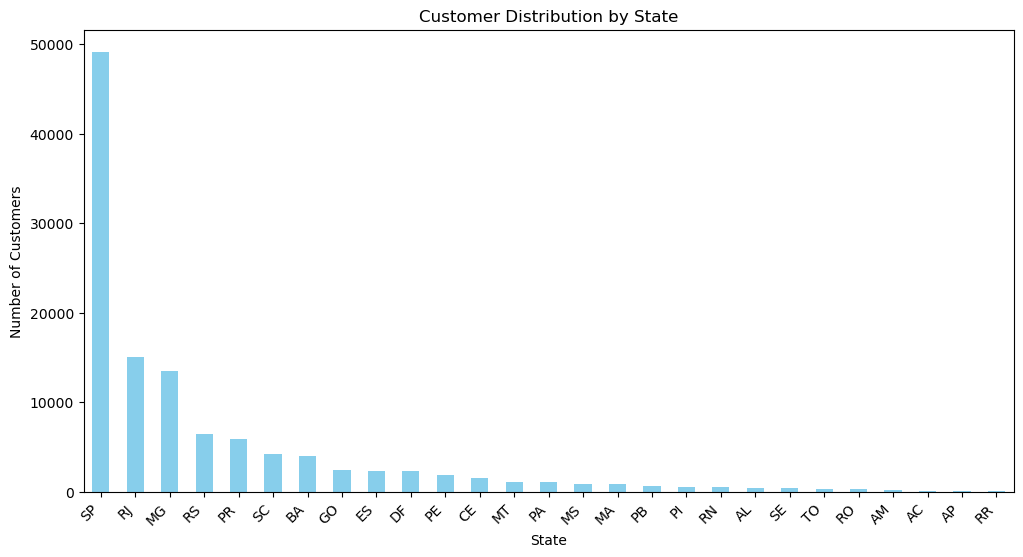

In [68]:
customer_state = df['customer_state'].value_counts()

plt.figure(figsize=(12, 6))
customer_state.plot(kind='bar', color='skyblue')
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')  
plt.show()

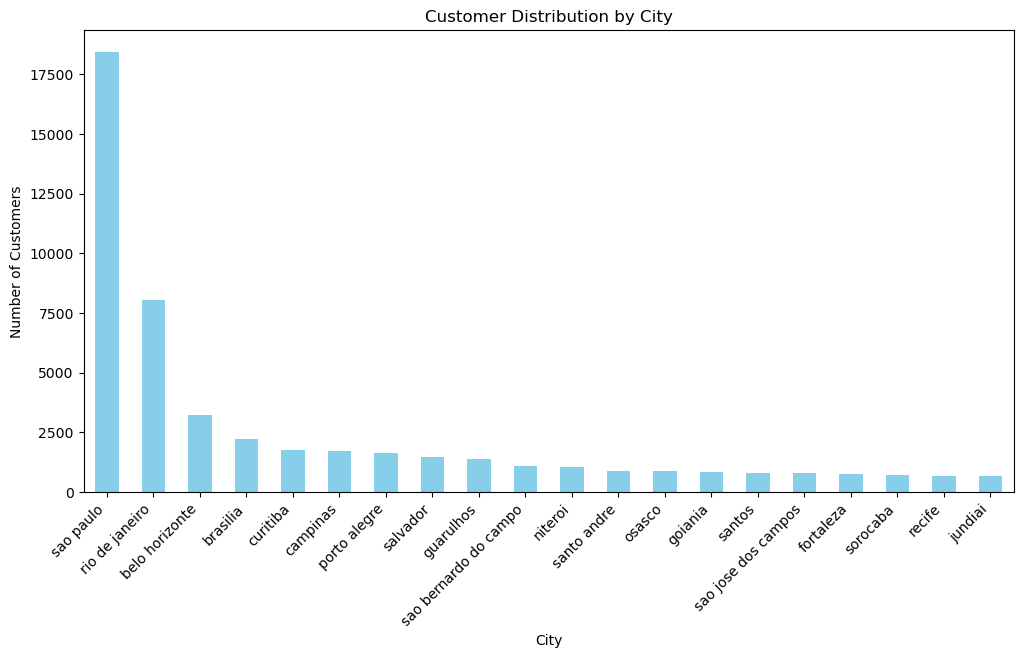

In [74]:
customer_state = df['customer_city'].value_counts().head(20)

plt.figure(figsize=(12, 6))
customer_state.plot(kind='bar', color='skyblue')
plt.title('Customer Distribution by City')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')  
plt.show()

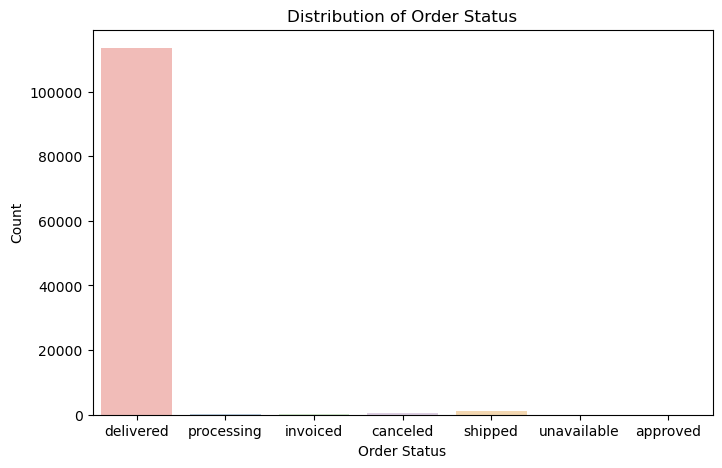

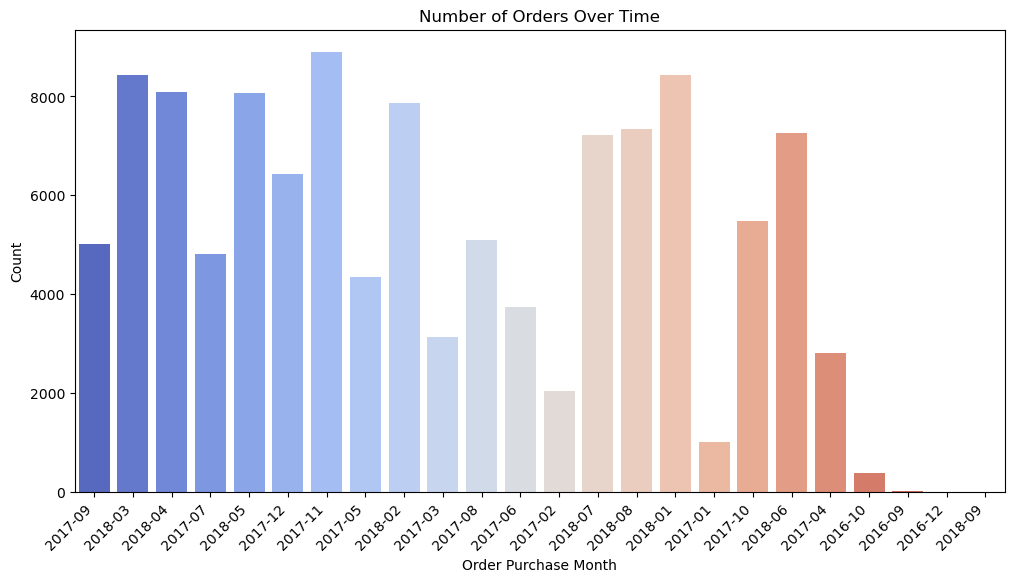

In [51]:
# Order Purchase Timestamp
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='order_purchase_month', palette='coolwarm')
plt.title('Number of Orders Over Time')
plt.xlabel('Order Purchase Month')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

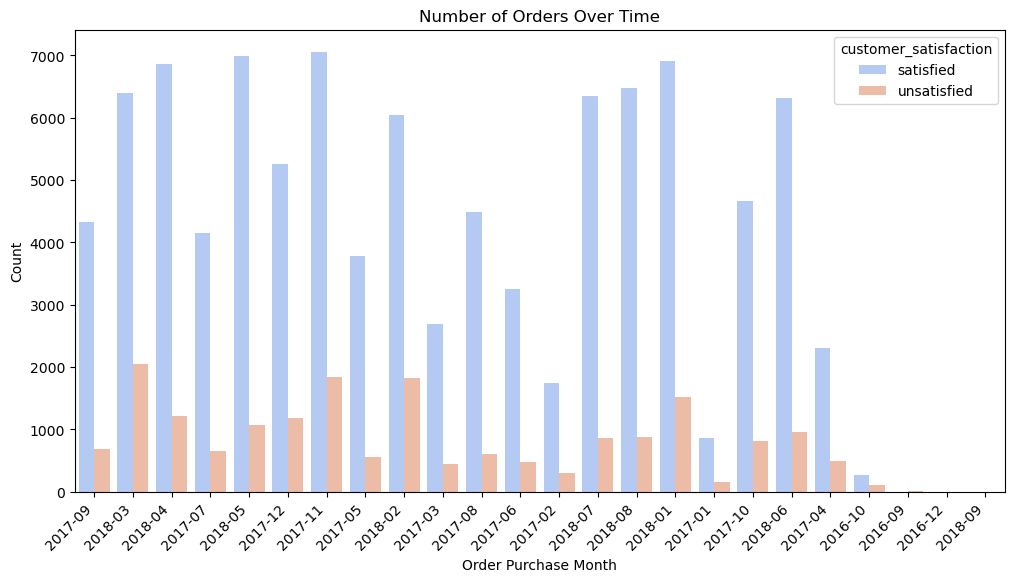

In [77]:
# Order Purchase Timestamp
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='order_purchase_month', hue='customer_satisfaction', palette='coolwarm')
plt.title('Number of Orders Over Time')
plt.xlabel('Order Purchase Month')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

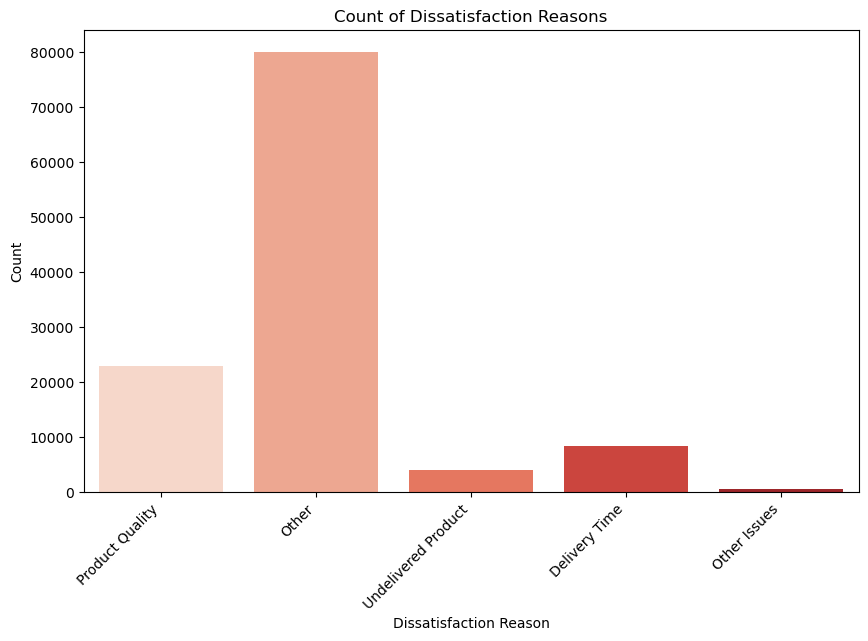

In [54]:
# Dissatisfaction Reasons
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dissatisfaction_reason', palette='Reds')
plt.title('Count of Dissatisfaction Reasons')
plt.xlabel('Dissatisfaction Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

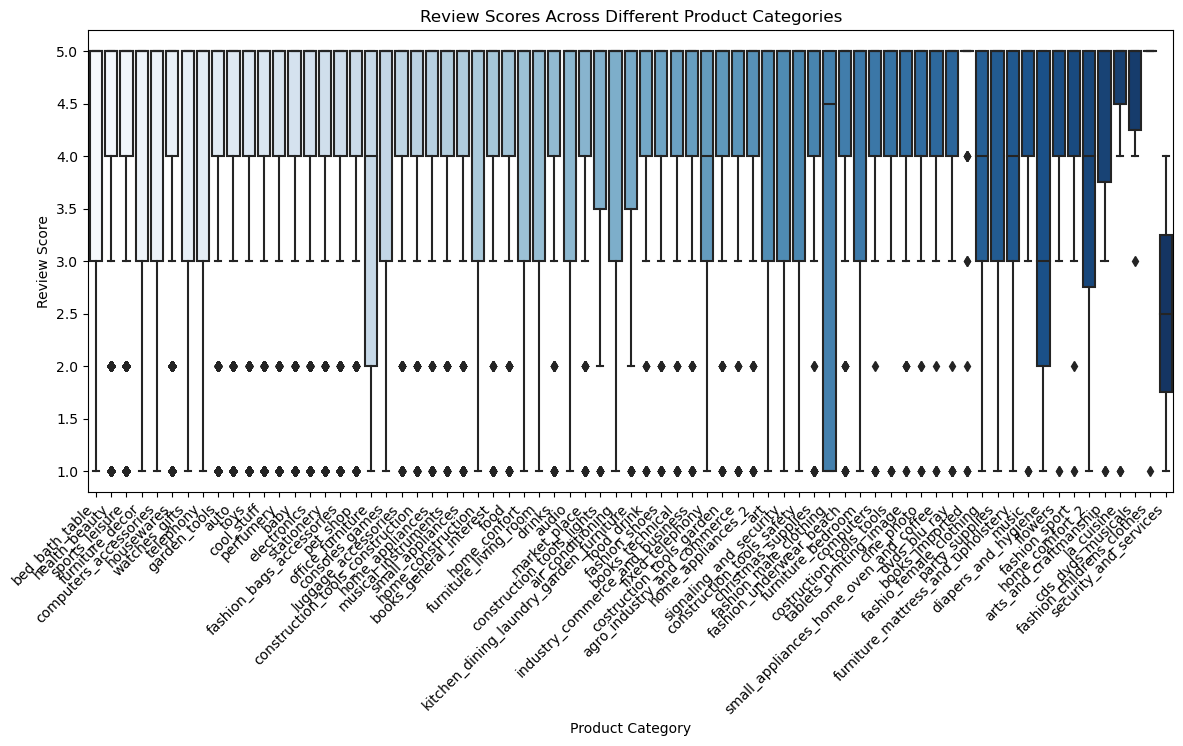

In [55]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='product_category_name_english', y='review_score', palette='Blues', order=df['product_category_name_english'].value_counts().index)
plt.title('Review Scores Across Different Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Review Score')
plt.xticks(rotation=45, ha='right')
plt.show()

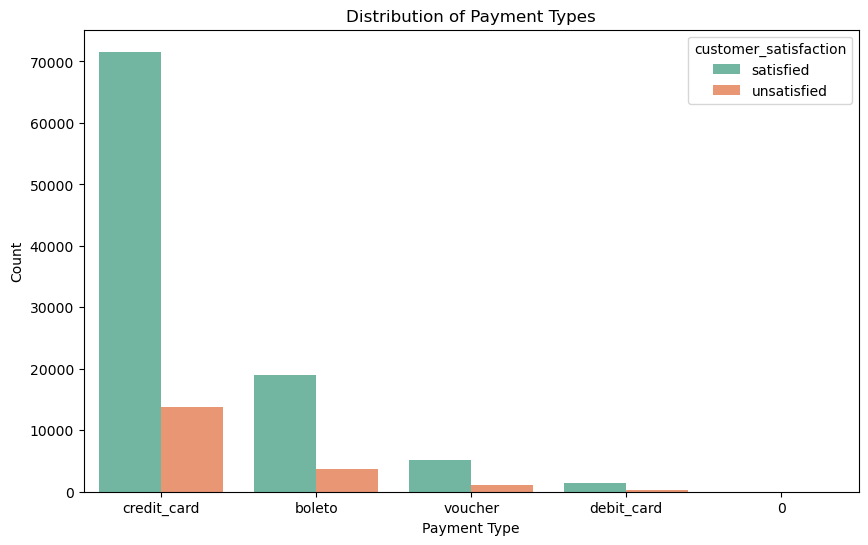

In [75]:
# Payment Types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='payment_type', hue='customer_satisfaction', palette='Set2')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

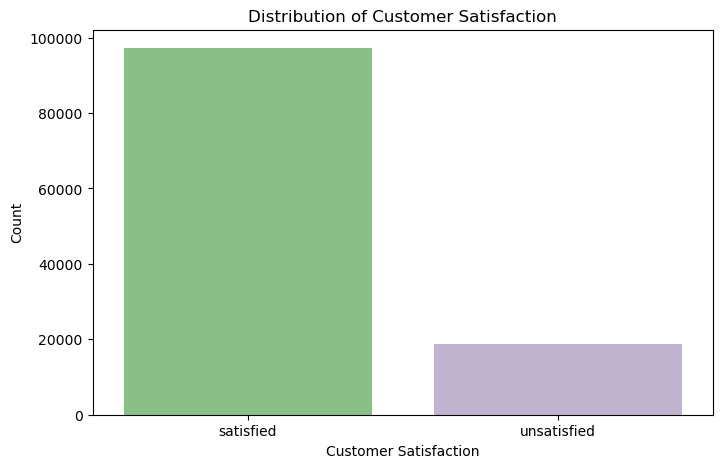

In [57]:
# Customer Satisfaction
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='customer_satisfaction', palette='Accent')
plt.title('Distribution of Customer Satisfaction')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Count')
plt.show()

# Split the prepared dataset

In [38]:
from sklearn.model_selection import train_test_split

X = df[['order_item_id', 'order_delivery_time', 'review_score_avg_review', 'payment_value', 'customer_reviewCount', 'payment_installments', 'payment_installments', 'payment_installments', 'freight_value', 
       'product_weight_g', 'price']]
y = df['customer_satisfaction']


# Splitting the data into training and  testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set (X_train, X_test):", X_train.shape, X_test.shape)
print("Testing set (y_train, y_test):", y_train.shape, y_test.shape)

Training set (X_train, X_test): (92703, 11) (23176, 11)
Testing set (y_train, y_test): (92703,) (23176,)


# Normalization

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
print("Training set (X_train_scaled, X_test_scaled):", X_train_scaled.shape, X_test_scaled.shape)

Training set (X_train_scaled, X_test_scaled): (92703, 11) (23176, 11)


converting scaled data into dataframe

In [41]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# calculating the payment price ration into price
X_train_scaled['payment_price_ratio'] = X_train_scaled['payment_value'] / X_train_scaled['price']
X_test_scaled['payment_price_ratio'] = X_test_scaled['payment_value'] / X_test_scaled['price']

check the relationship between order item id and product weight

Correlation Coefficient: 0.00033563198197038703


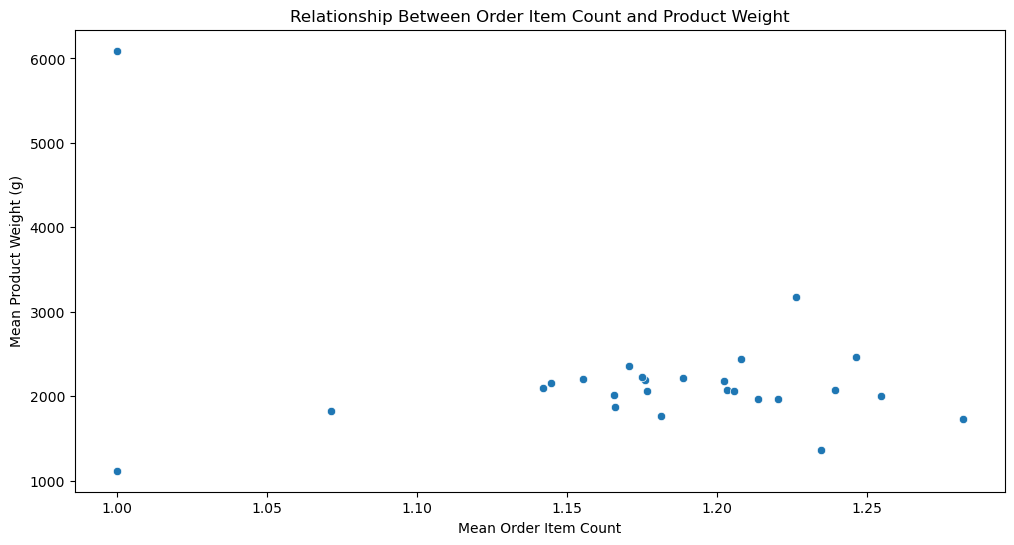

In [42]:
#converting delivered date to date time
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_month'] = df['order_delivered_customer_date'].dt.to_period('M')
aggregated_data = df.groupby('delivery_month').agg({'order_item_id': 'mean', 'product_weight_g': 'mean'})

# Creating a scatter plot to check the relationship between product weight and order item
plt.figure(figsize=(12, 6))
sns.scatterplot(data=aggregated_data, x='order_item_id', y='product_weight_g')
plt.title('Relationship Between Order Item Count and Product Weight')
plt.xlabel('Mean Order Item Count')
plt.ylabel('Mean Product Weight (g)')

correlation = df['order_item_id'].corr(df['product_weight_g'])
print(f"Correlation Coefficient: {correlation}")

plt.show()

The correlation coefficient is 0.0003 which means the relation between order item and product weight is very low.

# Model Selection

## Trying different model.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'KNN Model': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

accuracy_scores = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[model_name] = accuracy
results_table = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])
results_table

,Model,Accuracy
0,Logistic Regression,0.998706
1,KNN Model,0.994002
2,Decision Tree,0.997584
3,Random Forest,0.997713
4,Gradient Boosting,0.998576
5,Support Vector Machine,0.997497


Wow, the model is 99% accurate, this is very high, it might be due to over fitting becuase excessively high accuracy may occasionally indicate overfitting, a condition in which the model has become accustomed to memorizing training data rather than applying it to new data.

According to my research, random forest classifier is a good model for predicting customer satisfaction.
Also, 
Here, Random Forest Classifier is used for classification and regression tasks due to its high accuracy, robustness, and scalability. In addition, It reduces overfitting by averaging multiple decision trees and is less sensitive to noise and outliers in the data.


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [45]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9977131515360718


Since our model is 99% accurate, which might be due to overfitting, we would use the cross validation methond and fine-tune it using hyperparameter

In [46]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Performing the cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.99811229 0.99762688 0.99800442 0.99816613 0.99843581]
Mean Accuracy: 0.9980691074045819


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

   satisfied       1.00      1.00      1.00     19400
 unsatisfied       0.99      0.99      0.99      3776

    accuracy                           1.00     23176
   macro avg       1.00      1.00      1.00     23176
weighted avg       1.00      1.00      1.00     23176

Confusion Matrix:
 [[19375    25]
 [   28  3748]]


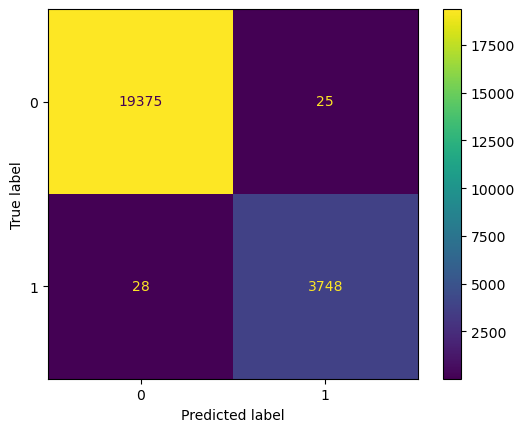

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, model.predict(X_test_scaled))
).plot();

Important information about the model's performance may be found in the confusion matrix. 
This is how it is interpreted:

- **True Positives (TP)**: 3,748 instances in which the model accurately predicted that the customers would be "satisfied".
- **True Negatives (TN)**: 19,375 instances when the model accurately predicted "unsatisfied" customers.
- **False Positives (FP)**: 25 instances in which the model predicted users to be "satisfied" when in fact they were "unsatisfied."
- **False Negatives (FN)**: 28 instances in which the model predicted "unsatisfied" clients while the true label was "satisfied."


In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_numeric = label_encoder.fit_transform(y_test)
y_pred_numeric = label_encoder.transform(y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)
print("ROC AUC:", roc_auc)

ROC AUC: 0.9956480429844489


# Hyperparameter Tuning

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy') 
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 300}


# Cross-Validation

We are using cross-validation using the best hyperparameter result to ensure that our model's performance is not just specific to the training split or test split

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=10, n_estimators=300)

# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.9984359  0.99854377 0.99795049 0.99848975 0.99881338]
Mean Accuracy: 0.9984466566326343


In [52]:
from joblib import dump, load

# Train the final model with the best hyperparameters on the full training data
final_model = RandomForestClassifier(max_depth=10, n_estimators=300)
final_model.fit(X_train_scaled, y_train)

# Save the trained model to a file
dump(final_model, 'customer_satisfaction_model.joblib')

['customer_satisfaction_model.joblib']

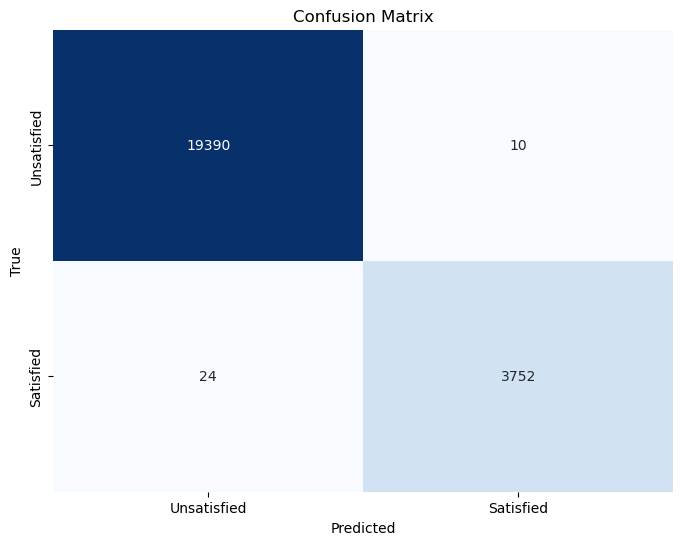

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = final_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Unsatisfied', 'Satisfied'],
            yticklabels=['Unsatisfied', 'Satisfied'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
conf_matrix

array([[19390,    10],
       [   24,  3752]], dtype=int64)

# Handling imbalanced data using SMOTE

In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Retrain the model on the resampled data
final_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set with the new predictions
y_pred_resampled = final_model.predict(X_test_scaled)
print("Classification Report on Resampled Data:\n", classification_report(y_test, y_pred_resampled))

Classification Report on Resampled Data:
               precision    recall  f1-score   support

   satisfied       1.00      1.00      1.00     19400
 unsatisfied       1.00      0.99      1.00      3776

    accuracy                           1.00     23176
   macro avg       1.00      1.00      1.00     23176
weighted avg       1.00      1.00      1.00     23176



# Interpretation

The classification report on the resampled data performed excelently on the model. 

- **Precision** : The precision for both the "satisfied" and "unsatisfied" classes is 1.00 (100%). This means that after using SMOTE to handle the imbalanced dataset, the model is making accurate predictions with no false positives.

- **Recall (Sensitivity)** : For "satisfied" customers, the recall is 1.00 (100%), indicating that the model captures all instances of satisfied customers. The recall for "unsatisfied" customers is 0.99 (99%), indicating that the model captures nearly all instances.

- **F1 Score** : For both classes, the F1 score is 1.00, which is the harmonic mean of precision and recall. This indicates that both classes have a perfect balance of precision and recall.

- **Accuracy** : The model's overall accuracy remains at 1.00 (100%), indicating that it correctly classifies all instances in the test set.

In summary, the classification report on the resampled data confirms your model's excellent performance and suggests that the model generalizes well to the imbalanced data.

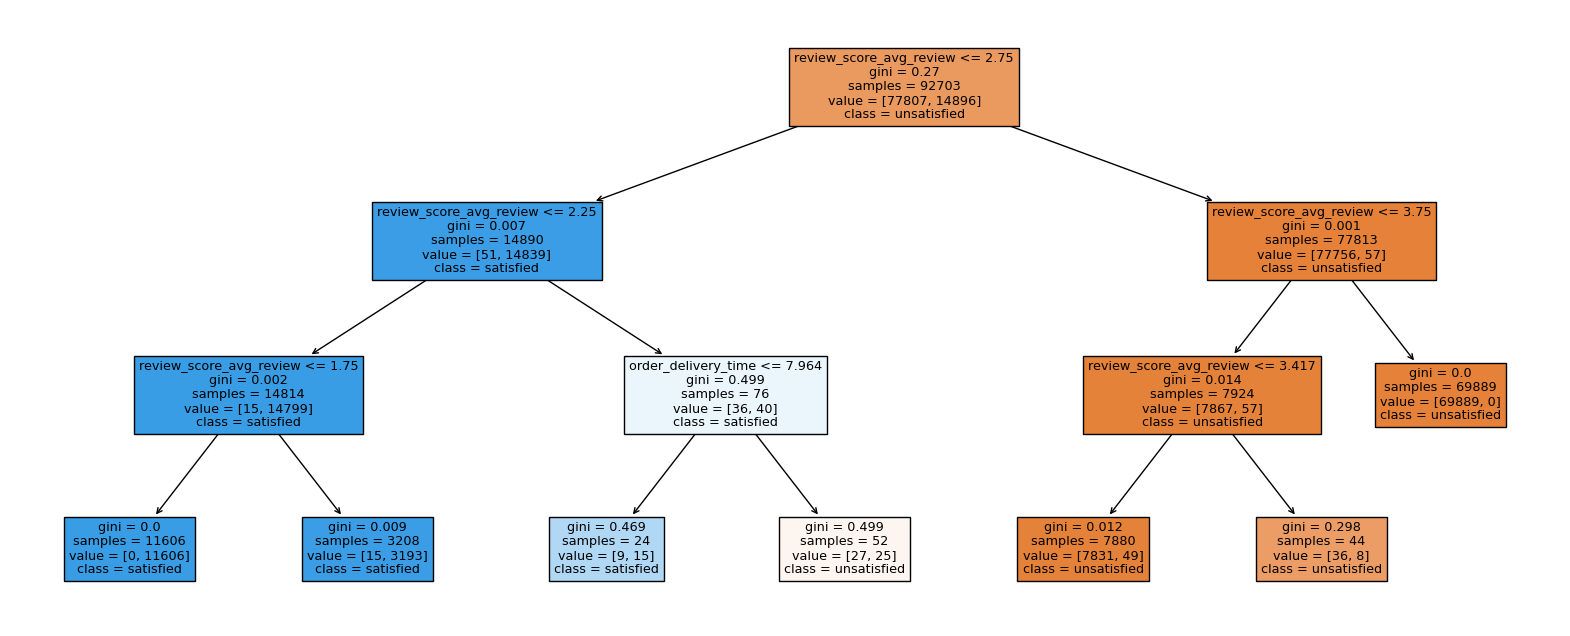

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create and fit a DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 8))
plot_tree(dt, feature_names=X.columns, class_names=['unsatisfied', 'satisfied'], filled=True)
plt.show()

In [57]:
# df.to_excel('customer_satisfaction.xlsx')

In [58]:
# loaded_model = load('customer_satisfaction_model.joblib')

# new_data = ...  # import the new data set for prediction
# predictions = loaded_model.predict(new_data)